In [93]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [94]:
# Load housing price data
X = pd.read_csv("house_params.csv")

In [95]:
# Get rid of NaN for target column
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)


In [96]:
# Get rid of columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()]
X.drop(cols_with_missing, axis=1, inplace=True)

In [97]:
# Break off validation set from training data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

rndmForest = RandomForestRegressor(n_estimators=10, 
                                    max_depth=5, min_samples_leaf=20, max_features=0.5, 
                                    n_jobs=-1, random_state=0)


In [98]:
# Option 1 : Get rid of categorical columns (dtype = 'object') 
X_train_drop = X_train.select_dtypes(exclude=['object'])
X_test_drop = X_test.select_dtypes(exclude=['object'])

# Fit model on base data
rndmForest.fit(X_train_drop, y_train)

# Importance of features
imp = pd.Series(rndmForest.feature_importances_)
imp.sort_values(ascending=False)

3     0.483154
24    0.101082
14    0.086858
17    0.074252
5     0.062722
23    0.060138
10    0.044916
11    0.020842
7     0.019384
2     0.010961
6     0.009354
21    0.007406
1     0.005173
12    0.004764
22    0.003425
25    0.002553
4     0.001477
15    0.001219
33    0.000321
8     0.000000
9     0.000000
16    0.000000
13    0.000000
32    0.000000
18    0.000000
19    0.000000
20    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
0     0.000000
dtype: float64

In [99]:
#Do preidictions and get MAE
y_predicts_test = rndmForest.predict(X_test_drop)
y_predicts_train = rndmForest.predict(X_train_drop)
mae1_test = mean_absolute_error(y_test,y_predicts_test)
mae1_train = mean_absolute_error(y_train,y_predicts_train)
print("MAE_test = ", mae1_test)
print("MAE_train = ", mae1_train)

# print('Train:')
# show_auc(y_train, y_predicts_train, 'train')
         
# print('Test:')
# show_auc(y_test, y_predicts_test, 'test')

MAE_test =  22186.910387846005
MAE_train =  20031.37123257425


In [100]:
# Option 2  - Label categorical data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_test[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_test = X_test.drop(bad_label_cols, axis=1)

# label encoder 
label = LabelEncoder() 
for col in set(good_label_cols):
    label_X_train[col] = label.fit_transform(X_train[col])
    label_X_test[col] = label.transform(X_test[col])

# Fit model    
rndmForest.fit(label_X_train, y_train)

# Importance of features
imp = pd.Series(rndmForest.feature_importances_)
imp.sort_values(ascending=False)



10    0.467607
23    0.118331
33    0.063292
20    0.055189
34    0.052665
12    0.048587
14    0.048452
26    0.047899
18    0.037129
15    0.018476
3     0.012261
21    0.009904
31    0.006592
13    0.002812
1     0.002173
19    0.001778
32    0.001556
36    0.000850
11    0.000759
8     0.000710
28    0.000685
24    0.000647
16    0.000599
0     0.000543
27    0.000314
17    0.000191
2     0.000000
7     0.000000
9     0.000000
4     0.000000
5     0.000000
6     0.000000
45    0.000000
44    0.000000
25    0.000000
29    0.000000
30    0.000000
35    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
22    0.000000
dtype: float64

In [101]:
# Option 2 : Predict
y_predicts_test = rndmForest.predict(label_X_test)
y_predicts_train = rndmForest.predict(label_X_train)
mae2_test = mean_absolute_error(y_test,y_predicts_test)
mae2_train = mean_absolute_error(y_train,y_predicts_train)
print("MAE2_test = ", mae2_test)
print("MAE2_train = ", mae2_train)


MAE2_test =  21209.319955660583
MAE2_train =  19390.172332286147


In [113]:
#function to choose X_train by MAE
def X_better(mae1, mae2):
    if mae1_test > mae2_test:
        print("Better Option 2, MAE2_test = {} when MAE1_test = {}, label_X_train".format(mae2_test, mae1_test))
        return label_X_train
    else:
        print("Better Option 1, MAE1_test = {} when MAE2_test = {}, X_train_drop ".format(mae1_test, mae2_test))
        return X_train_drop


In [114]:
# Use Stacking
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
import numpy as np
import matplotlib.pyplot as plt

estimators = [
    ('lr', LinearRegression()),
    ('svr', SVR(kernel='linear')),
    ('rd', Ridge(random_state=11))
]

final_estimator = SVR(kernel='linear')

regressor = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator
)

X_better_train = X_better(mae1_test, mae2_test)

regressor.fit(X_better_train, y_train)

Better Option 2, MAE2_test = 21209.319955660583 when MAE1_test = 22186.910387846005, label_X_train


StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('svr', SVR(kernel='linear')),
                              ('rd', Ridge(random_state=11))],
                  final_estimator=SVR(kernel='linear'))

In [115]:
regressor.named_estimators_

{'lr': LinearRegression(),
 'svr': SVR(kernel='linear'),
 'rd': Ridge(random_state=11)}

In [116]:
y_pred = regressor.predict(X_better_train)
y_pred

array([313568.82022859,  91846.32685091, 124552.72686006, ...,
       139101.94097139, 203491.0313492 , 212658.24433138])

In [117]:
# MSE and VS

print("Mean Squared Error: %.4f"
      % np.mean((regressor.predict(X_better_train) - y_train) ** 2))
print('Variance Score: %.4f' % regressor.score(X_better_train, y_train))


Mean Squared Error: 900731423.6706
Variance Score: 0.8537


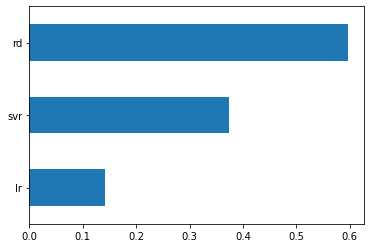

In [118]:
pd.Series(regressor.final_estimator_.coef_.flatten(), index=regressor.named_estimators_.keys()).plot(kind='barh')
